This Notebook lives at [Github](https://github.com/petermchale/yeast_bioinformatics). Follow [these instructions](http://jupyter.readthedocs.io/en/latest/install.html) to execute the Notebook using Python 3.x.  Otherwise, [view this Notebook](http://nbviewer.jupyter.org/github/petermchale/yeast_bioinformatics/blob/master/analysis.ipynb) in read-only mode using [Jupyter Notebook Viewer](http://nbviewer.jupyter.org/).

In [1]:
import os
repository_directory = os.getcwd() 
package_directory = repository_directory + '/source'
import sys
sys.path.append(package_directory)
print('Modules are now visible to the Notebook')

Modules are now visible to the Notebook


# Transcription Factor-DNA binding in yeast

Written by [Peter McHale](http://ccbs-76.bio.uci.edu/~petermchale/). 

The eukaryotic genome is adorned by molecules called transcription factors (TFs) that bind a small number of target promoters to regulate gene transcription. But do they also bind other genomic locations that do not directly influence transcription rates? To approach this question, we first need to quantify the strength with which TFs bind DNA. Denote by $E(\vec{s})$ the binding energy of a TF to a sequence 

\begin{equation} 
\vec{s} = \langle s_1, s_2, \ldots, s_L\rangle
\end{equation} 

of $L$ nucleotides $s_i \in \{A,C,G,T\}$. With binding lengths of $L = 10-20$ nucleotides, the number of possible sequences is too large to measure individually. Fortunately, the contribution of each nucleotide to the binding energy of the parent sequence is approximately independent and additive: 

\begin{equation} 
E(\vec{s}) = \sum_{i=1}^L \epsilon_i(s_i),
\end{equation}

reducing the impractical problem of determining the large number of values of $E(\vec{s})$ to the practical problem of the determining the 
 $L\times 4$ energy matrix, $\epsilon_i(s)$. This matrix can be determined for Gal4 using *in vitro* measurements of the equilibrium binding constants 
 
\begin{equation} 
K(\vec{s}) \propto e^{-\beta E(\vec{s})} 
\end{equation} 

for all sequences $\vec{s}$ that differ in just one nucleotide from a given sequence, which I manually fetched from the literature [[Liang et al 1996](https://www.ncbi.nlm.nih.gov/pubmed/8668194)], and stored as a list of dictionaries: 

In [2]:
from extract import createEnergyMatrix
matrix = createEnergyMatrix('data/Gal4_affinity.in')

We can get a feel for what these data look like with the aid of `pandas`:

In [3]:
import pandas as pd 
df = pd.DataFrame(matrix)
df

,A,C,G,T
0,2.426816,0.000000,3.132951,2.957252
1,3.800451,3.800451,0.000000,3.800451
2,3.800451,3.800451,0.000000,3.800451
3,0.000000,0.804719,0.601986,0.885978
4,0.143841,0.000000,0.693147,0.000000
5,0.693147,0.143841,0.693147,0.000000
6,0.000000,1.497866,1.103637,0.000000
7,0.554331,0.000000,1.609438,0.693147
8,0.000000,2.120264,2.120264,0.000000
9,0.693147,1.609438,0.000000,0.554331


In the above data structure:
* row labels are positions within a binding site
* column labels are the identities of nucleotides at those positions
* matrix elements are TF-DNA binding energies

So, for example, a DNA sequence that binds optimally to Gal4 can be extracted by listing the nucleotides with the lowest energy at each position:



In [4]:
print(df.idxmin(axis=1))

0     C
1     G
2     G
3     A
4     C
5     T
6     A
7     C
8     A
9     G
10    A
11    A
12    A
13    T
14    C
15    C
16    G
dtype: object


Next, I manually downloaded the DNA sequence of the third chromosome of the model organism, yeast, and read it into this notebook:

In [5]:
from extract import getFasta
with open('data/chr03.fsa') as f:
    [header, sequence] = getFasta(f)
print('Here is the header information of a fasta file:\n')
print(header)
print('\nAnd here is the beginning of the DNA sequence of the chromosome:\n')
print(sequence[:100])
print('\nThere are ', len(sequence), 'nucleotides in this chromosome')

Here is the header information of a fasta file:

>ref|NC_001135| [org=Saccharomyces cerevisiae] [strain=S288C] [moltype=genomic] [chromosome=III]

And here is the beginning of the DNA sequence of the chromosome:

CCCACACACCACACCCACACCACACCCACACACCACACACACCACACCCACACACCCACACCACACCACACCCACACCACACCCACACACCCACACCCAC

There are  316617 nucleotides in this chromosome


With the energy matrix and chromosome sequence in hand, I next computed the energy with which Gal4 binds every possible sequence on the chromosome:

In [10]:
from auxFunctions import calcEnergyListWithMatrix
energyList = calcEnergyListWithMatrix(sequence, matrix)

Here is how those TF-DNA binding energies are distributed:

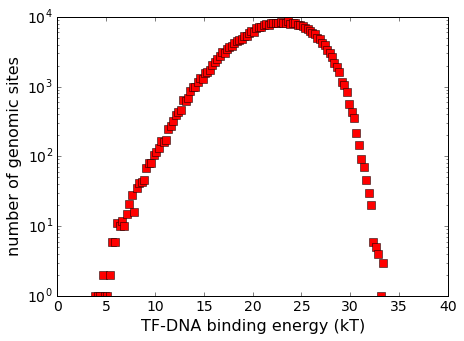

In [11]:
import numpy as np 
from matplotlib import pyplot as plt
from auxFunctions import binList
%matplotlib inline

fontsize = 16
fontsize_tick = 14

bL = binList(energyList, xMin=-5.0, xMax=50, binWidth=0.25)
bindingEnergies = [t[0] for t in bL]
numberSites = [t[1] for t in bL]

fig = plt.figure(figsize=(7,5), facecolor='w')
ax = fig.add_subplot(111)
ax.plot(bindingEnergies, numberSites, linewidth=0, marker='s', markersize=8, color='red')
ax.set_xlabel('TF-DNA binding energy (kT)', fontsize=fontsize)
ax.set_ylabel('number of genomic sites', fontsize=fontsize)
ax.set_yscale('log')
ax.set_xlim(0, 40)
ax.tick_params(axis='both', which='major', labelsize=fontsize_tick)

Though highly-specific (low-energy) sites do indeed exist, the sheer number of less-specific (intermediate- to high-energy) sites across the genome can, in principle, soak up a significant number of TFs. 